In [2]:
__author__ = 'Kayli Glidic'

# Import Library

In [3]:
#import the module
from tshirt.pipeline import spec_pipeline

import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

output_notebook()

#import yaml to read in the parameter file
import yaml

#imports to use RECTE
import os
from astropy.table import QTable
import astropy.units as u
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table, join
import pandas as pd
from astropy.time import Time


#import to copy
from copy import deepcopy

#modeling light curves
from scipy.optimize import curve_fit
import batman

#to fix errors
import pdb

#to correct for time differences
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation

from scipy.optimize import minimize
import time
from multiprocessing import Pool
import corner
import emcee


Loading BokehJS ...

# Applying RECTE

In [4]:
import Charge_Correction_Functions
from Charge_Correction_Functions import RECTE,RECTEMulti,calculate_correction, calculate_correction_fast, charge_correction

Loading BokehJS ...

In [5]:
bspec = spec_pipeline.batch_spec(batchFile='corot1_batch_file.yaml')
result = bspec.batch_run('get_wavebin_series',nbins=10, recalculate=True)
spec_v1 = bspec.return_spec_obj(ind=0)
spec_v2 = bspec.return_spec_obj(ind=1)
spec_v3 = bspec.return_spec_obj(ind=2)
spec_v4 = bspec.return_spec_obj(ind=3)

Working on get_wavebin_series for batch CoRoT-1 corot1_visit1 
Working on get_wavebin_series for batch CoRoT-1 corot1_visit2 
Working on get_wavebin_series for batch CoRoT-1 corot1_visit3 
Working on get_wavebin_series for batch CoRoT-1 corot1_visit4 


In [6]:
#read in result files
corot1_visit1_results = pd.read_csv('CSV_Visit_Files/corot1_visit1_results.csv')
corot1_visit2_results = pd.read_csv('CSV_Visit_Files/corot1_visit2_results.csv')
corot1_visit3_results = pd.read_csv('CSV_Visit_Files/corot1_visit3_results.csv')
corot1_visit4_results = pd.read_csv('CSV_Visit_Files/corot1_visit4_results.csv')

#read in median fit files
median_image_v1 = fits.getdata('Median_Images/corot1_visit1_median_image.fits')
median_image_v2 = fits.getdata('Median_Images/corot1_visit2_median_image.fits')
median_image_v3 = fits.getdata('Median_Images/corot1_visit3_median_image.fits')
median_image_v4 = fits.getdata('Median_Images/corot1_visit4_median_image.fits')

In [9]:
#getting the values for planet radius and semi-major axis in units of stellar radii

#planet radius (in units of stellar radii)
rp =1.715 * u.Rjupiter #Bonomo et al. 2017
Rstar = 1.230 * u.Rsun #Bonomo et al. 2017
planet_radius = (rp/Rstar).si.value
#planet_radius = 0.1433 #Bean 2009

#semi-major axis (in units of stellar radii)
a = 0.02752 * u.au  #Bonomo et al. 2017
a_over_r = (a/Rstar).si.value
#a_over_r = 4.751 #Bean 2009

params_transit = batman.TransitParams()       #object to store transit parameters

params_transit.t0 = 2454138.32807 #Mid-point(days) Bonomo et al. 2017       #time of inferior conjunction
params_transit.per = 1.5089682  #(days) Bonomo et al. 2017                  #orbital period
#params_transit.rp =  planet_radius #Bonomo et al. 2017                      #planet radius (in units of stellar radii)
params_transit.a = a_over_r #Bonomo et al. 2017                             #semi-major axis (in units of stellar radii)
params_transit.inc =85.15 #Bonomo et al. 2017#83.88   #Bean 2009            #orbital inclination (in degrees)
params_transit.ecc = 0.     #Bonomo et al. 2017                             #eccentricity
params_transit.w = 90.                                                      #longitude of periastron (in degrees)
params_transit.limb_dark = "nonlinear"                                      #limb darkening model
params_transit.u = [0.5, 0.1, 0.1, -0.1]                                    #limb darkening coefficients [u1, u2, u3, u4]

def transit_model(x, rp, a, b):
    '''
    Models transit light curve based on initial parameters
    
    Parameters
    ----------
    
    x: 
        Time in Julian days 
    rp: int
        Radius of the planet
    a: int
        Flux Normalization value
    b: int
        Slope Flux Normalization value
    '''
    params_transit.rp = rp
    m = batman.TransitModel(params_transit, x)
    #Modifying the slope: Julian Date - Initial Julian Date 
    x0 = np.min(x)
    flux = m.light_curve(params_transit)*(a+b*(x-x0))
    return flux

#one must define the global parameters im, exptime, and xList for each visit
def transit_model_RECTE(x, rp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f):
    '''
    Models transit light curve based on initial parameters and RECTE corrections
    
    Parameters
    ----------
    
    x: 
        Time in Julian days 
    rp: int
        Radius of the planet
    a: int
        Flux Normalization value
    b: int
        Slope Flux Normalization value
        
    trap_pop_s: int
        (default=0)number of initially occupied traps -- slow poplulation
        
    trap_pop_f: int
        (default=0)number of initially occupied traps -- fast poplulation
    
    dtrap_s: int
        (default=0, can be either number or list) number of extra
        trapped charge carriers added in the middle of two orbits
        -- slow population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
    
    dtrap_f: int
        (default=0, can be either number or list) number of extra
         trapped charge carriers added in the middle of two orbits
        -- fast population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
        
    '''
    global im
    global exptime
    global xList
    
    flux = transit_model(x,rp,a,b)
    ramp=calculate_correction_fast(x,exptime,im,xList=xList,trap_pop_s=trap_pop_s, dTrap_s=[dtrap_s], trap_pop_f=trap_pop_f, dTrap_f=[dtrap_f])
    flux_modified = flux*np.mean(ramp,axis=0)
    return flux_modified

params_eclipse = batman.TransitParams()       #object to store transit parameters

params_eclipse.t0 = 2454138.32807 #Mid-point(days) Bonomo et al. 2017       #time of inferior conjunction
params_eclipse.per = 1.5089682  #(days) Bonomo et al. 2017                  #orbital period
params_eclipse.rp =  planet_radius #Bonomo et al. 2017                      #planet radius (in units of stellar radii)
params_eclipse.a = a_over_r #Bonomo et al. 2017                             #semi-major axis (in units of stellar radii)
params_eclipse.inc =85.10   #Bonomo et al. 2017        #orbital inclination (in degrees)
params_eclipse.ecc = 0.     #Bonomo et al. 2017                             #eccentricity
params_eclipse.w = 90.                                                      #longitude of periastron (in degrees)
params_eclipse.limb_dark = "nonlinear"                                      #limb darkening model
params_eclipse.u = [0.5, 0.1, 0.1, -0.1]                                    #limb darkening coefficients [u1, u2, u3, u4]

#parameters for modeling eclipses 
#specify the planet-to-star flux ratio and the central eclipse time:
params_eclipse.t_secondary = params_eclipse.t0 + 0.5* 1.5089682

#adding a new parameter b for new normalization (a+b*x)
def eclipse_model(x, fp, a, b):
    '''
    Models eclipse light curve based on initial parameters
    
    Parameters
    ----------
    
    x: 
        Time in days 
        
    fp: int
        planet-to-star flux ratio
        
    a: int
        Flux Normalization value
        
    b: int
        Slope Flux Normalization value
        
    '''
    params_eclipse.fp = fp/1000000
    m = batman.TransitModel(params_eclipse, x, transittype="secondary")
    #Modifying the slope: Julian Date - Initial Julian Date 
    x0 = np.min(x)
    flux = m.light_curve(params_eclipse)*(a+b*(x-x0)) 
    return flux

#one must define the global parameters im, exptime, and xList for each visit
def eclipse_model_RECTE(x, fp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f):
    '''
    Models eclipse light curve based on initial parameters and RECTE corrections
    
    Parameters
    ----------
    
    x: 
        Time in days 
    fp: int
        Planet-to-flux ratio
    a: int
        Flux Normalization value
        
    b: int
        Slope Flux Normalization value
        
    trap_pop_s: int
        (default=0)number of initially occupied traps -- slow poplulation
    
    trap_pop_f: int
        (default=0)number of initially occupied traps -- fast poplulation
    
    dTrap_s: int
        (default=0, can be either number or list) number of extra
        trapped charge carriers added in the middle of two orbits
        -- slow population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
        
     dtrap_f: int
        (default=0, can be either number or list) number of extra
         trapped charge carriers added in the middle of two orbits
        -- fast population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
        
    '''
    global im
    global exptime
    global xList
    
    flux = eclipse_model(x,fp,a,b)
    ramp=calculate_correction_fast(x,exptime,im,xList=xList,trap_pop_s=trap_pop_s, dTrap_s=[dtrap_s], trap_pop_f=trap_pop_f, dTrap_f=[dtrap_f])
    flux_modified = flux*np.mean(ramp,axis=0)
    return flux_modified
    

# if you needed to define an object spec 
#relPath = '/home/kglidic/Software/tshirt_files/tshirt/Corot1_Data/corot1_batch_file.yaml'
#specPath = os.path.join(spec_pipeline.baseDir,relPath)
#spec = spec_pipeline.batch_spec(specPath)

def barycenter_correction(self):
    t1, t2 = self.get_wavebin_series()
    head = fits.getheader(self.fileL[0])
    #print("Time from tshirt: {}".format(t1['Time'][0]))
    
    expStartJD = head['EXPSTART'] + 2400000.5
    #print("Time from EXPSTART keyword {}".format(expStartJD))
    
    t1 = Time(t1['Time'][0],format='jd')
    coord = SkyCoord('06 48 19.1724141241 -03 06 07.710423478',unit=(u.hourangle,u.deg))
    loc = EarthLocation.of_site('keck')
    diff = t1.light_travel_time(coord,location=loc)
    #print('Travel Time from Keck to Barycenter= {} min'.format((diff / u.min).si))
    
    return (diff / u.day).si


In [12]:
def optimize_batman_model_RECTE(self,model,nbins=10,showPlot=False, recalculate=False):
    '''
    Optimize Light curves with RECTE charge trapping correction
    
    Parameters
    ----------
    model: function
        The function that models either transits or eclipses. Must be previously defined
        
    nbins: int
        The number of wavelength bins 
        
    showPlot: bool
            Make the plot visible? 
        '''
    global xList
    
    results = self.get_wavebin_series(nbins=nbins)
    raw_results = results[0].to_pandas()
    raw_results_errors = results[1].to_pandas()
    
    columns = raw_results.columns
    columns_errors = raw_results_errors.columns
    
    #barycenter time correction in days 
    time_correction = barycenter_correction(self)
    
    ydata = raw_results.columns[1:].values
    xdata = raw_results['Time'].values+time_correction #days correction for Solar barycenter
    ydata_errors = raw_results_errors.columns[1:].values
     
    table_noise = self.print_noise_wavebin(nbins=nbins)
    table_noise=table_noise.to_pandas()
    
    wavelength = self.wavecal(table_noise['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
    
    if(showPlot==True):
        fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(20,10),sharey=False)
    
    xList_all = []
    for ind in table_noise.index: 
        Disp_st = table_noise['Disp St'][ind]
        Disp_end = table_noise['Disp End'][ind]
        Disp_xList = np.arange(Disp_st, Disp_end,1)
        xList_all.append(Disp_xList)
    
    popt_list=[]
    pcov_list=[]
    

    if(model==transit_model_RECTE):
        text = 'fit: pr=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
        p0 = [0.13,1.0,0.0,200,200,20,1]
    elif(model ==eclipse_model_RECTE):
        text = 'fit: fp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
        p0 = [500,1.0,0.0,200,200,20,1]
    
    else: 
        print("invalid")
        
    color_idx = np.linspace(0.3, 0.8, nbins)

    for columns, columns_errors,i,j,k,l in zip(ydata,ydata_errors,xList_all,np.arange(nbins),color_idx,wavelength):
        xList = i

        xdata_trimmed = xdata
        ydata_trimmed = raw_results[columns]
        ydata_error_trimmed = raw_results_errors[columns_errors].tolist()
        
        
        #results_file = 'opt_result_tables/new_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)
        results_file = 'opt_result_tables/Fast&Slow_Trap_Populations_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)

        if (os.path.exists(results_file) == True ) and (recalculate == False):
            dat = ascii.read(results_file)
            popt = np.array(dat['popt'])
            pcov_diag = np.array(dat['pcov_diag'])
              
        else:
            bounds =([-np.inf,0,-np.inf,0,0,0,0],[np.inf,np.inf,np.inf,500,500,200,200])
            popt, pcov = curve_fit(model,xdata_trimmed,ydata_trimmed, sigma=ydata_error_trimmed,p0=p0,bounds=bounds)
            pcov_diag = np.sqrt(np.diag(pcov))
            dat = Table()
            dat['popt'] = popt
            dat['pcov_diag'] = pcov_diag
            dat.write(results_file)


        popt_list.append(popt)
        pcov_list.append(pcov_diag)
        #yerr = [row[0] for row in pcov_list]
        
        if(showPlot==True):

            
            #lightcurve_file = 'model_lightcurves/new_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)
            lightcurve_file = 'model_lightcurves/Fast&Slow_Trap_Populations_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)

            if (os.path.exists(lightcurve_file) == True ) and (recalculate == False):
                dat = ascii.read(lightcurve_file)
                Time = np.array(dat['Time'])

                if np.allclose(Time,xdata,rtol=1e-15) == False:
                    raise Exception("times don't match")
                ymodel = np.array(dat['ymodel'])
                ramp_model = np.array(dat['ramp_model'])
            else: 
                ymodel =model(xdata, *popt)
                ramp=calculate_correction_fast(xdata,exptime,im,xList=xList,trap_pop_s=popt[3], dTrap_s=[popt[4]], trap_pop_f=popt[5], dTrap_f=[popt[6]])
                ramp_model = np.mean(ramp,axis=0)
                dat = Table()
                dat['Time'] = xdata
                dat['ymodel'] = ymodel
                dat['ramp_model'] = ramp_model
                dat.write(lightcurve_file)
                

            #plotting all four orbits : first plot is the model with RECTE, 2nd plot is the data with the systematic removed.
            offset = 0.007
            
            ax.plot(xdata, ymodel-j*offset, 'r-',
                    label=text % tuple(popt))
            ax.plot(xdata, raw_results[columns]-j*offset,'o',color=plt.cm.gist_heat(k),alpha=0.8)
            ax.set_xlabel('Time (BJD)')
            ax.set_ylabel('Normalized Flux')
            ax.set_title('Raw Uncorrected Light Curves')
            #ax.legend()
            ax.annotate("{:.2f}".format(l), xy =(np.mean(xdata_trimmed)-0.1, np.mean(ydata_trimmed)-j*offset+0.004),fontsize=15,weight='bold',color=plt.cm.gist_heat(k))
            
            ax2.plot(xdata,(raw_results[columns]/ramp_model)-j*offset,'o',color=plt.cm.gist_heat(k),alpha=0.8)
            ax2.plot(xdata, (ymodel/ramp_model)-j*offset, 'r-',
                    label=text % tuple(popt))
            #ax2.set_ylabel('Normalized Flux')
            ax2.set_xlabel('Time (BJD)')
            ax2.set_title('RECTE Corrected Light Curves')
            ax2.annotate("{:.2f}".format(l), xy =(np.mean(xdata_trimmed)-0.1, np.mean(ydata_trimmed)-j*offset+0.004),fontsize=15,weight='bold')


            #ax2.legend()
            
            ax3.plot(xdata, (raw_results[columns]-ymodel)-j*offset,'o',color=plt.cm.gist_heat(k))
            ax3.set_ylabel('Residuals')
            ax3.set_xlabel('Time (BJD)')
            ax3.set_title('Residuals')
            #ax3.annotate(columns, xy =(np.mean(xdata_trimmed)+0.05, np.mean(ydata_trimmed)-j*offset))
        
        
        #figure_name='saved_figures/new_Corot1_{}_lightcurves.pdf'.format(self.param['nightName'])   
        #fig.savefig(figure_name)

    return popt_list,pcov_list

KeyboardInterrupt: 

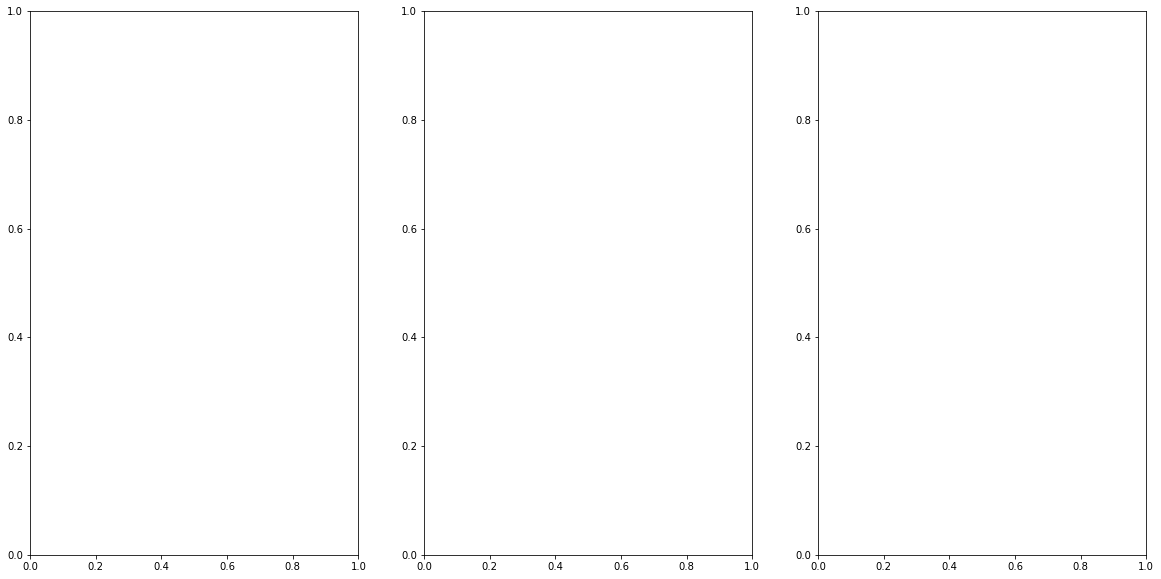

In [11]:
start = time.time()

#optimizing/plotting visit 1 wavebin channels with RECTE
info_v1 = corot1_visit1_results
exptime = info_v1['Exp Time'][0]
im = fits.getdata('corot1_visit1_median_image.fits')

v1_wavebin_channels = optimize_batman_model_RECTE(spec_v1,transit_model_RECTE,nbins=10,showPlot=True)
end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
start = time.time()

#optimizing/plotting visit 1 wavebin channels with RECTE
info_v2 = corot1_visit2_results
exptime = info_v2['Exp Time'][0]
im = fits.getdata('corot1_visit2_median_image.fits')

v2_wavebin_channels = optimize_batman_model_RECTE(spec_v2,eclipse_model_RECTE,nbins=10,showPlot=True)
end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
start = time.time()

#optimizing/plotting visit 1 wavebin channels with RECTE
info_v3 = corot1_visit3_results
exptime = info_v3['Exp Time'][0]
im = fits.getdata('corot1_visit3_median_image.fits')

v3_wavebin_channels = optimize_batman_model_RECTE(spec_v3,eclipse_model_RECTE,nbins=10,showPlot=True)
end = time.time()

print(f"Runtime of the program is {end - start}")

In [ ]:
start = time.time()

#optimizing/plotting visit 1 wavebin channels with RECTE
info_v4 = corot1_visit4_results
exptime = info_v4['Exp Time'][0]
im = fits.getdata('corot1_visit4_median_image.fits')

v4_wavebin_channels = optimize_batman_model_RECTE(spec_v4,eclipse_model_RECTE,nbins=10,showPlot=True)
end = time.time()

print(f"Runtime of the program is {end - start}")

In [20]:
#wavebins values 
xc0_v1 = 75.36  
yc0_v1 = 71.57

xc0_v2 = 73.593  
yc0_v2 = 73.2098 

xc0_v3 = 75.0211
yc0_v3= 71.4784

xc0_v4=75.3891
yc0_v4=71.4633

#calibrations 
table_noise_v1=spec_v1.print_noise_wavebin(nbins=10)
table_noise_v2=spec_v2.print_noise_wavebin(nbins=10)
table_noise_v3=spec_v3.print_noise_wavebin(nbins=10)
table_noise_v4=spec_v4.print_noise_wavebin(nbins=10)

dismid_v1 = table_noise_v1['Disp Mid']
dismid_v2 = table_noise_v2['Disp Mid']
dismid_v3 = table_noise_v3['Disp Mid']
dismid_v4 = table_noise_v4['Disp Mid']

wavebins_v1 = spec_v1.wavecal(dismid_v1,waveCalMethod = 'wfc3Dispersion')
wavebins_v2 = spec_v2.wavecal(dismid_v2,waveCalMethod = 'wfc3Dispersion')
wavebins_v3 = spec_v3.wavecal(dismid_v3,waveCalMethod = 'wfc3Dispersion')
wavebins_v4 = spec_v4.wavecal(dismid_v4,waveCalMethod = 'wfc3Dispersion')

In [21]:
def log_likelihood(theta, x, y, yerr):
    fp,a,b,trap_pop_s,dtrap_s  = theta
    model = eclipse_model_RECTE(x, fp, a, b, trap_pop_s, dtrap_s)
    return -0.5 * np.sum((y - model) ** 2 / yerr ** 2)

def log_prior(theta):
    fp,a,b,trap_pop_s,dtrap_s  = theta
    if 0.0 < trap_pop_s < 10**4 and 0.0 < dtrap_s < 10**4 :
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if np.isfinite(lp):
        return lp + log_likelihood(theta, x, y, yerr)
    return -np.inf

In [75]:
def MCMC(self,model,curvefit_channel,iterations,nbins=10,recalculate=False,showPlot=False):
    
    results = self.get_wavebin_series(nbins=nbins)
    raw_results = results[0].to_pandas()
    raw_results_errors = results[1].to_pandas()
    
    columns = raw_results.columns
    columns_errors = raw_results_errors.columns
    
    #barycenter time correction in days 
    time_correction = barycenter_correction(self)
    
    ydata = raw_results.columns[1:].values
    xdata = raw_results['Time'].values+time_correction #days correction for Solar barycenter
    ydata_errors = raw_results_errors.columns[1:].values
    
    #read in optimized error array and average each parameter for each wavebin for each visit
    error_2D = np.array(curvefit_channel[1])
    bad_points = np.isfinite(error_2D) == False
    error_2D[bad_points] = np.nan
    avg_error=np.nanmean(error_2D, axis=0)
    
    if(model==transit_model_RECTE):
        labels = ["pr", "a", "b","trap_pop_s","dtrap_s"]
        p0 = [0.13,1.0,0.0,200,100]
    elif(model ==eclipse_model_RECTE):
        labels = ["fp", "a", "b","trap_pop_s","dtrap_s"]
        p0 = [500,1.0,0.0,200,100]
    
    else: 
        print("invalid")
    
    q50_array =[]
    q16_array =[]
    q84_array =[]
    
    #if(showPlot==True):
    fig, ax2 = plt.subplots(figsize=(10,7))

    for columns, columns_errors,j in zip(ydata,ydata_errors,np.arange(nbins)):

        ydata_trimmed = raw_results[columns].values
        ydata_errors_trimmed = raw_results_errors[columns_errors].values

        start_2 = time.time()

        result_file = 'opt_result_tables/MCMC13000_soln.x_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)
        if (os.path.exists(result_file) == True):
            dat = ascii.read(result_file)
            soln_xarray = dat['soln']
        else:
            dat = Table()
            #run MCMC
            nll = lambda *args: -log_probability(*args)
            initial = np.array([p0[0],p0[1], p0[2], p0[3],p0[4]])
            soln = minimize(nll, initial, args=(xdata, ydata_trimmed, ydata_errors_trimmed))
            soln_xarray = soln.x
            dat['soln'] = soln['x']
            dat.write(result_file)
        end_2 = time.time()
        innertime= end_2-start_2
        print("Solution_x took {0:.1f} seconds".format(innertime))


        nwalkers = 10
        ndim = 5
        sampler_array = []

        pos = np.empty([nwalkers,ndim])
        for i, j, k in zip(avg_error,soln_xarray,np.arange(ndim)):
            if k == 3 or k == 4:
                pos[:,k] = np.random.rand(nwalkers) * 500
            else: 
                pos[:,k] = j + i* np.random.randn(nwalkers)*10            

        filename = '/fenrirdata1/kg_data/sample_chains/MCMC13000_visits_{}_wavelength_ind_{}_nbins{}.h5'.format(self.param['nightName'],columns,nbins)
        
        if (os.path.exists(filename) == True) and (recalculate == False):
            sampler = emcee.backends.HDFBackend(filename, read_only=True)
            check_size = sampler.get_chain()
            print("Path Found") 
            print("Found"+" "+str(check_size.shape[0])+" "+"iterations")

            if (check_size.shape[0] < iterations):
                print("Found"+" "+str(check_size.shape[0])+" "+"iterations")
                with Pool(16) as pool:
                    new_backend = emcee.backends.HDFBackend(filename)
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xdata, ydata_trimmed, ydata_errors_trimmed), backend=new_backend, pool=pool)
                    sampler.run_mcmc(None, iterations-check_size.shape[0], progress=True, store =True)

                    #sampler = emcee.EnsembleSampler(nwalkers, ndim,log_probability, args=(xdata, ydata_trimmed, ydata_errors_trimmed), backend=run2_backend, pool=pool)
                    #sampler.run_mcmc(pos, iterations-samples.shape[0], progress=True, store =True);


        else:
            with Pool(16) as pool:
                start = time.time()

                backend = emcee.backends.HDFBackend(filename)

                # Initialize the sampler
                sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xdata, ydata_trimmed, ydata_errors_trimmed),backend=backend,pool=pool)
                sampler.run_mcmc(pos, iterations, progress=True,store=True);
                

                end = time.time()
                multi_time = end - start
            print("Multiprocessing took {0:.1f} seconds".format(multi_time))
            
        tau = sampler.get_autocorr_time(quiet=True)
        burnin = int(2 * np.max(tau))
        thin = int(0.5 * np.min(tau))
        print("Auto_Correlation Time: {0}".format(tau))
        print("burn-in: {0}".format(burnin))
        print("thin: {0}".format(thin))
        
        flat_samples = sampler.get_chain(discard=burnin,thin=thin,flat=True)
        
        #Percentile 50
        q50 = np.percentile(flat_samples,50,axis=0)
        q50_array.append(q50)
        
        #Percentile 16; Lower Unccertainty Limit
        q16 = np.percentile(flat_samples,16,axis=0)
        q16_array.append(q50-q16)
        
        #Percentile 84; Upper Unccertainty Limit
        q84 = np.percentile(flat_samples,84,axis=0)
        q84_array.append(q84-q50)


        if(showPlot==True):
            fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
            
            samples = sampler.get_chain()


            for k in range(ndim):
                ax = axes[k]
                ax.plot(samples[:, :, k], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[k])
                ax.yaxis.set_label_coords(-0.1, 0.5)
            axes[-1].set_xlabel("step number");
            
            corner.corner(flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84],show_titles=True);
        

        
        inds = np.random.randint(len(flat_samples), size=10)
        offset = 0.1
        for ind in inds:
            sample = flat_samples[ind]
            ymodel=model(xdata, sample[0], sample[1], sample[2], sample[3], sample[4])
            ax2.plot(xdata, ymodel-j*offset, "C1", alpha=0.1)
        
        ax2.errorbar(xdata, raw_results[columns]-j*offset, yerr=raw_results_errors[columns_errors], fmt=".k", capsize=0)
        #plt.plot(xdata, raw_results[columns], "k", label="truth")
        #plt.legend(fontsize=14)
        #plt.xlim(0, 10)
        #plt.xlabel("x")
        #plt.ylabel("y");



    return q50_array,q16_array,q84_array

Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [ 95.67828101 107.39025715 109.98498579 118.83839323 111.94023605]
burn-in: 237
thin: 47
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [71.1734947  77.59941185 75.90964377 97.11689319 89.85397855]
burn-in: 194
thin: 35
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [78.29957836 78.97658933 79.30707413 76.43655524 85.50674409]
burn-in: 171
thin: 38
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [278.18841941 170.35921157 223.50427157 449.22732518 639.70540545]


Auto_Correlation Time: [278.18841941 170.35921157 223.50427157 449.22732518 639.70540545]
burn-in: 1279
thin: 85
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [ 77.27125766  74.24197997  72.64776581 110.33203466 117.10687517]
burn-in: 234
thin: 36
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [ 92.79770731  87.63513698  85.68963643  97.40382336 127.71531016]
burn-in: 255
thin: 42
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [ 78.33911189  82.32105152  80.18013247  86.18027379 113.40594839]
burn-in: 226
thin: 39
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [107.18037458 102.10626634 104.40695156 153.784907   198.18316198]
burn-in: 396
thin: 51
Solution_x took 0.0 seconds
Path Found
Found 20000 iterations
Auto_Correlation Time: [166.75600667 169.33633117 131.72172599 103.71847485 190.34492844]
burn-in: 380
thin: 51
Solution_x took 0

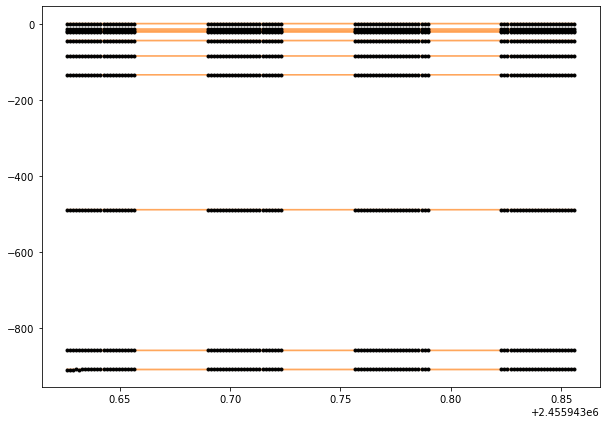

In [76]:
import emcee
start = time.time()

#optimizing/plotting visit 2 wavebin channels with RECTE
info_v2 = corot1_visit2_results
exptime = info_v2['Exp Time'][0]
im = fits.getdata('corot1_visit2_median_image.fits')

sampler_2 = MCMC(spec_v2,eclipse_model_RECTE,v2_wavebin_channels,20000,nbins=10,recalculate=False,showPlot=False)
end= time.time()
print(f"Runtime of the program is {end - start} seconds")

In [554]:
sampler_2[3].shape

(5210, 5)

In [77]:
time = corot1_visit2_results['Time'].values
sample = sampler_2[3][1000]
print(sample)
model=eclipse_model_RECTE(time, sample[0], sample[1], sample[2], sample[3], sample[4])

plt.plot(time,model)
#plt.plot(time, ) compare with real data 

IndexError: tuple index out of range

[-276.8120399393732, 470.5922355383599, 33.315078773119836, 805.1702480569504, 934.6836724438856, 489.4181016718868, 1312.941150858529, 1329.6741857073948, 1671.8354531006012, 1947.075013969176]


Text(0, 0.5, 'fp')

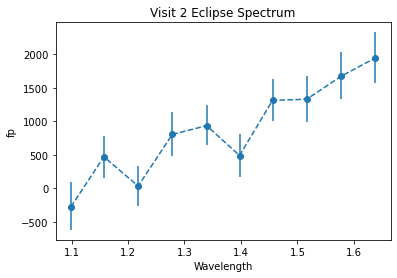

In [548]:
q50_values_2=[item[0] for item in sampler_2[0]]
lower_limit=[item[0] for item in sampler_2[1]]
upper_limit = [item[0] for item in sampler_2[2]]
print(q50_values_2)
plt.errorbar(wavebins_v2,q50_values_2,yerr=[lower_limit, upper_limit],fmt='--o')
plt.title("Visit 2 Eclipse Spectrum")
plt.xlabel("Wavelength")
plt.ylabel("fp")

Solution_x took 0.0 seconds
found
Auto_Correlation Time: [109.07488449 102.44727603 107.44511259 219.19800982 125.47434354]
burn-in: 438
thin: 51


Solution_x took 0.0 seconds
found


N/50 = 400;
tau: [ 112.7963213   444.59983934  122.10878507  330.10887186 1099.37586262]


Auto_Correlation Time: [ 112.7963213   444.59983934  122.10878507  330.10887186 1099.37586262]
burn-in: 2198
thin: 56


Solution_x took 0.0 seconds
found
Auto_Correlation Time: [66.71837253 75.17480504 81.85513684 91.94119234 74.92553762]
burn-in: 183
thin: 33
Solution_x took 0.0 seconds
found


N/50 = 400;
tau: [148.08702653 294.83099895 159.1012728  248.09199161 483.29582263]


Auto_Correlation Time: [148.08702653 294.83099895 159.1012728  248.09199161 483.29582263]
burn-in: 966
thin: 74
Solution_x took 0.0 seconds
found


N/50 = 400;
tau: [154.33887281 311.04610767 144.48832273 291.12109318 628.70135054]


Auto_Correlation Time: [154.33887281 311.04610767 144.48832273 291.12109318 628.70135054]
burn-in: 1257
thin: 72
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [120.28105206 219.98748375 140.10134561 249.86068022 301.47235665]
burn-in: 602
thin: 60
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [ 95.68688405 129.14946301 108.41110612 155.32000602 215.73316873]
burn-in: 431
thin: 47
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [131.66007599 264.6620409  155.71510868 294.87744273 383.7890987 ]
burn-in: 767
thin: 65
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [ 75.96828714  86.58107409  83.36482859  96.61527461 120.71040353]
burn-in: 241
thin: 37


Solution_x took 0.0 seconds
found
Auto_Correlation Time: [ 80.01251951  76.74749481  77.06883395 112.44561089 118.45957477]
burn-in: 236
thin: 38
Runtime of the program is 21.266979932785034 seconds


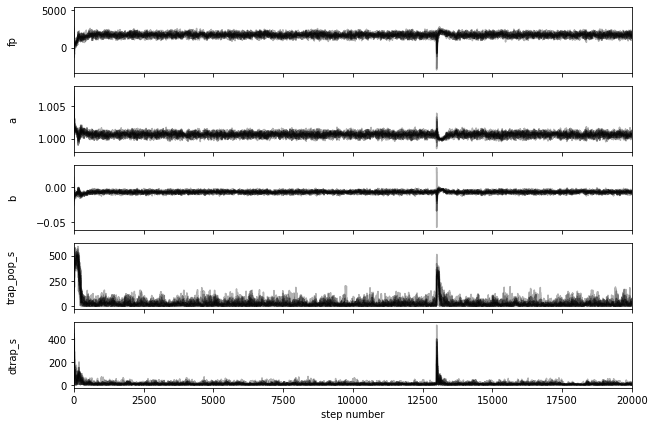

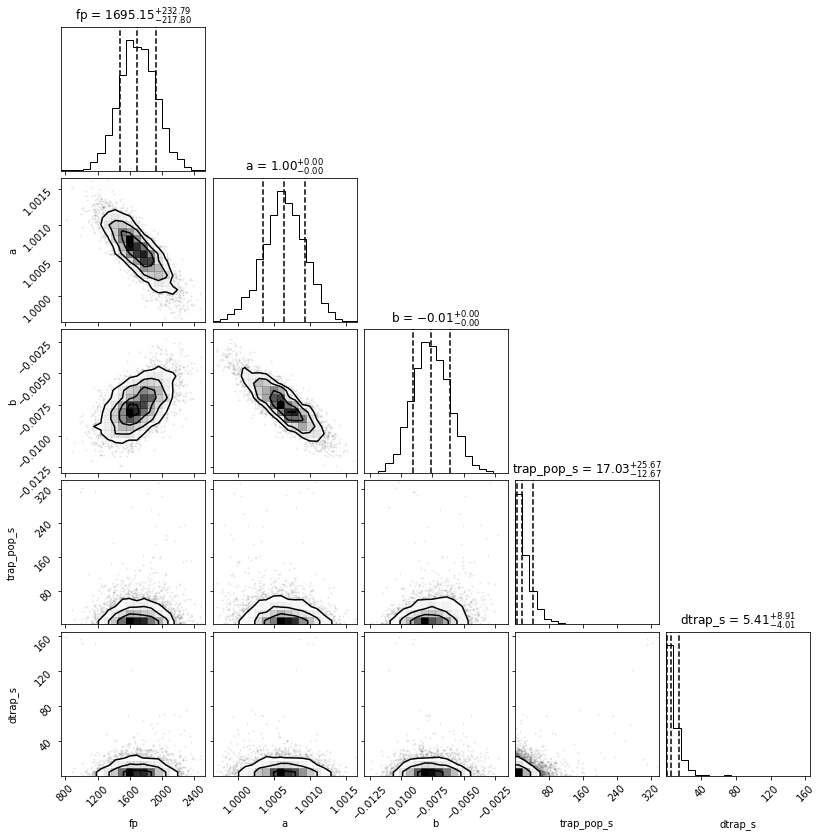

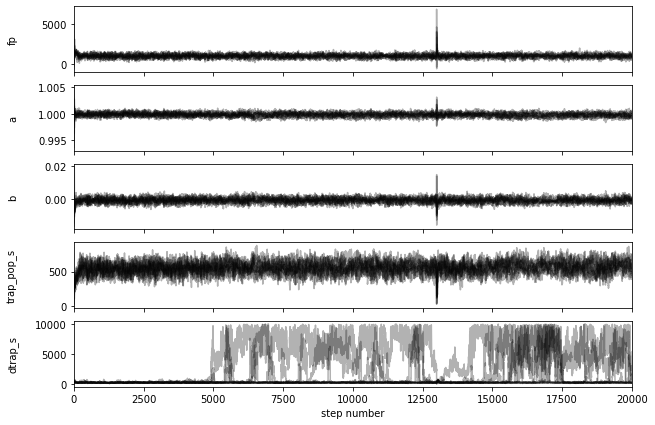

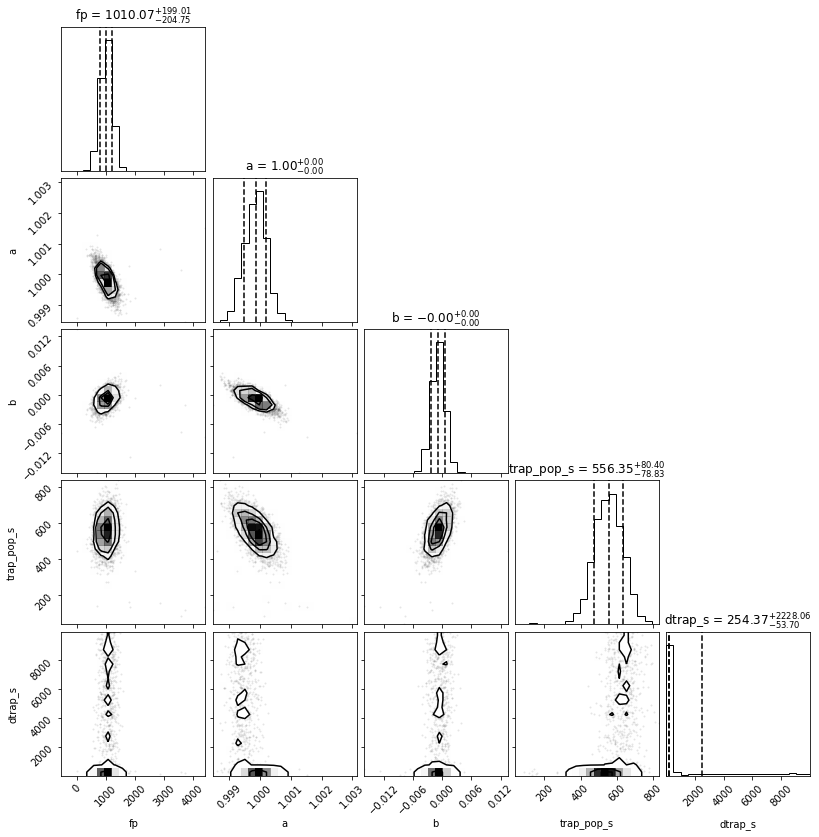

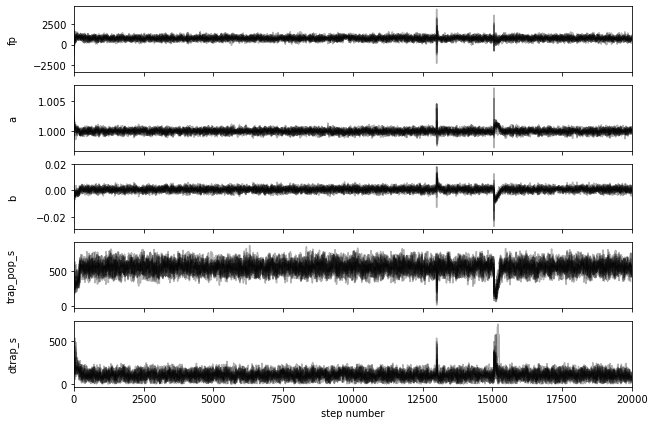

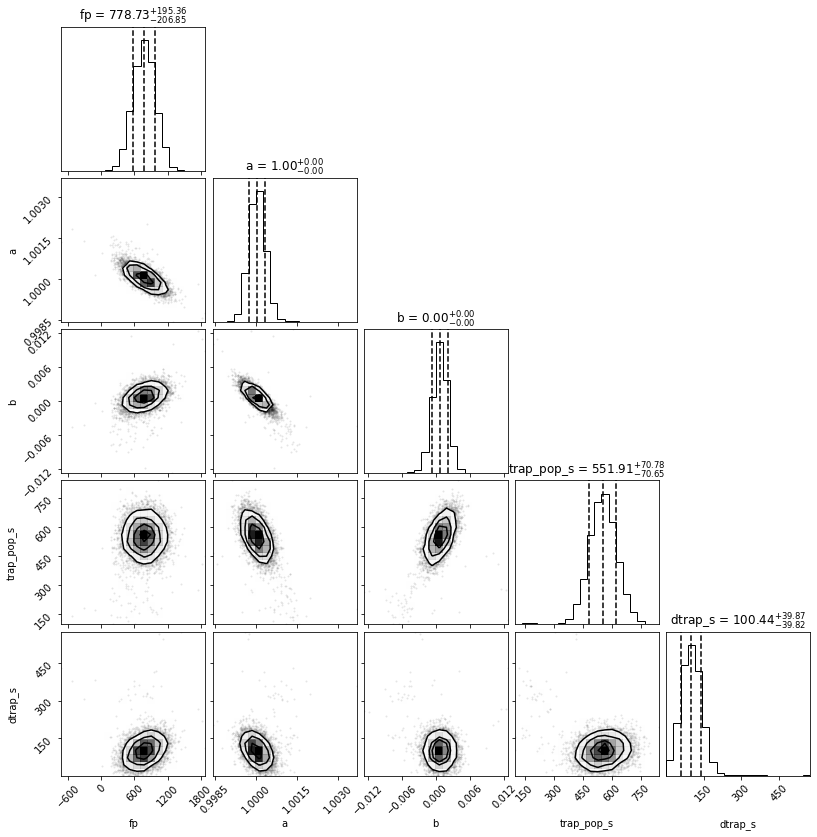

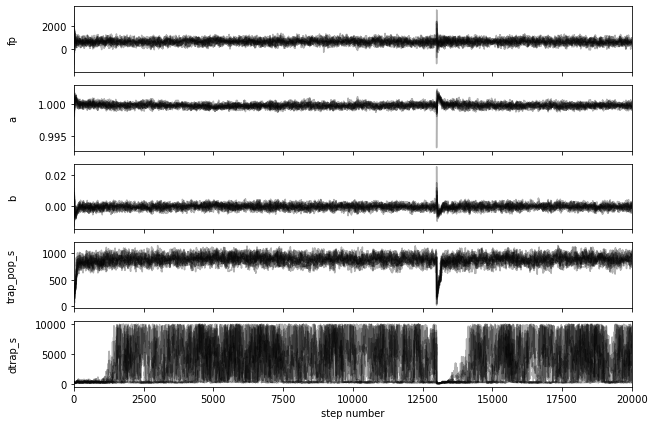

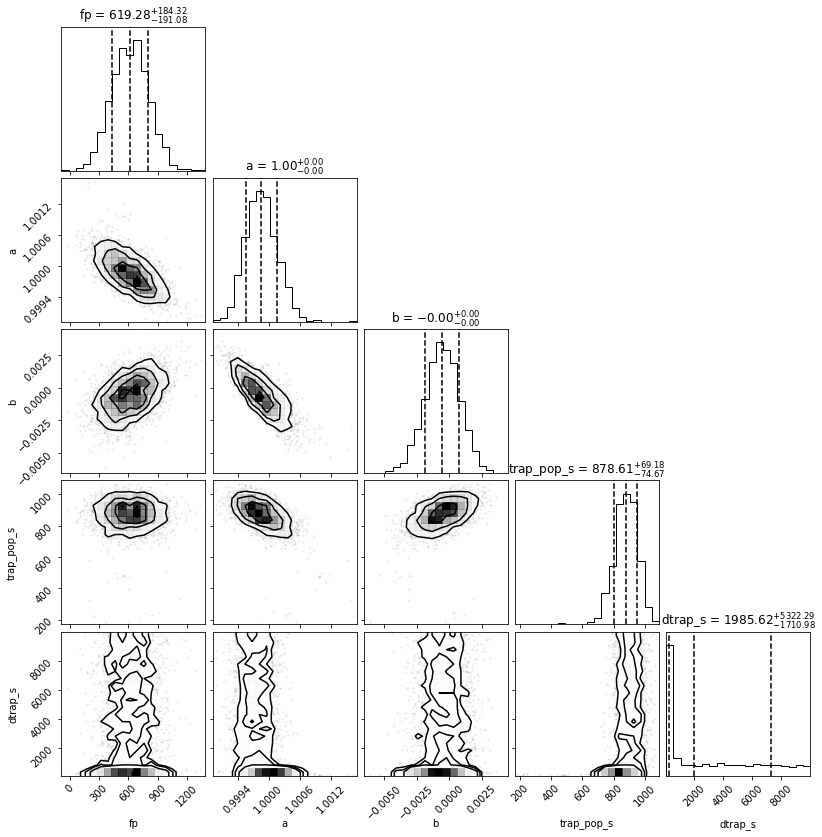

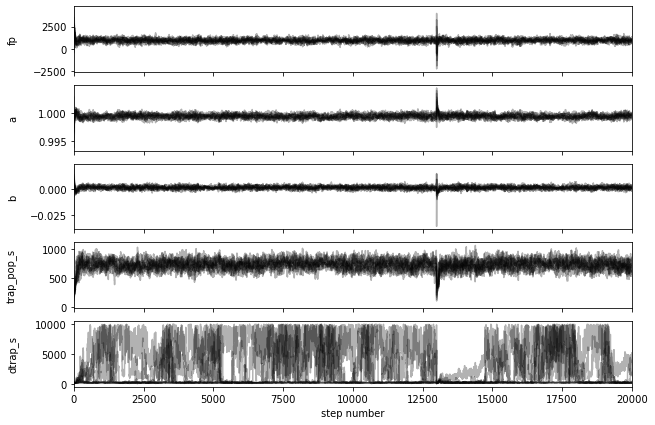

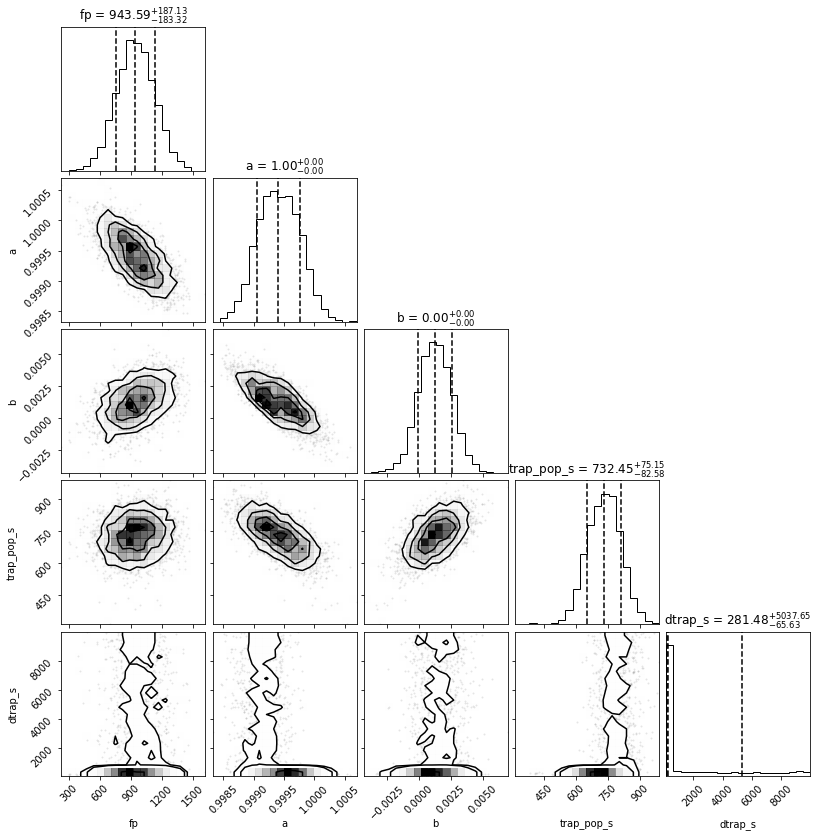

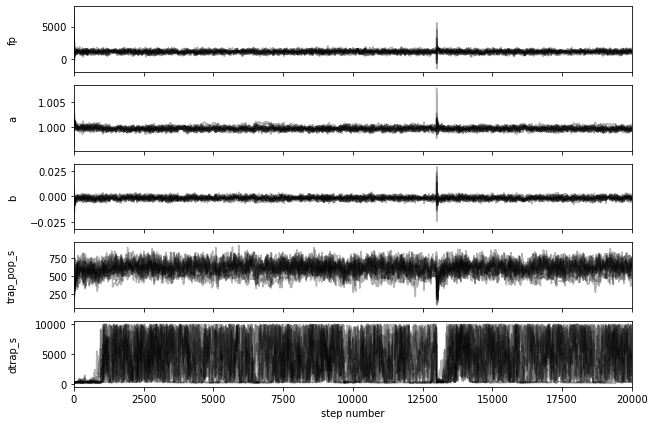

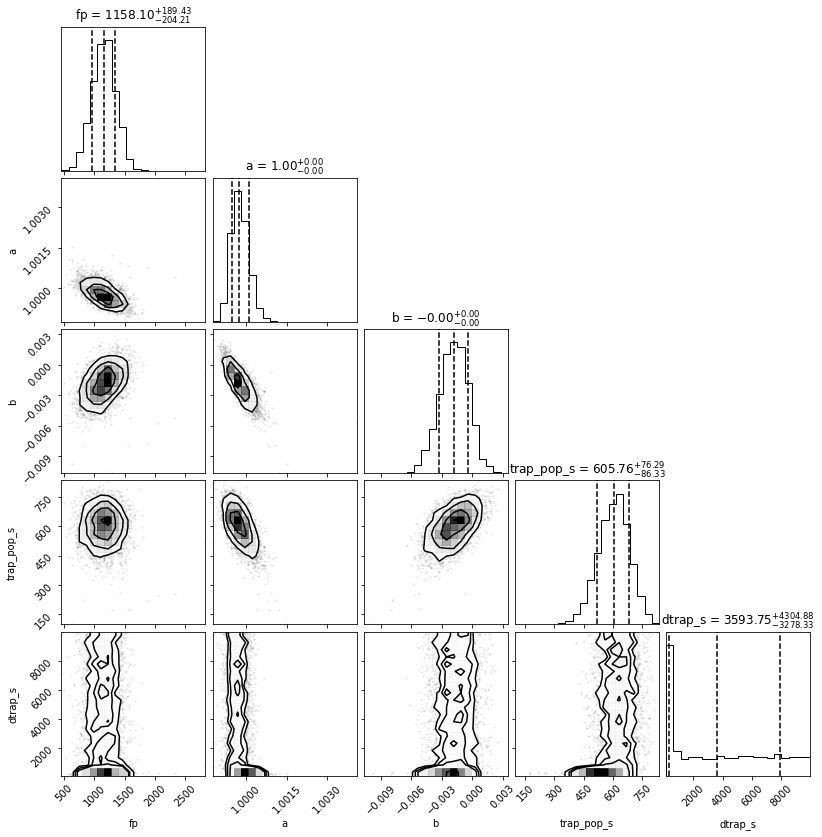

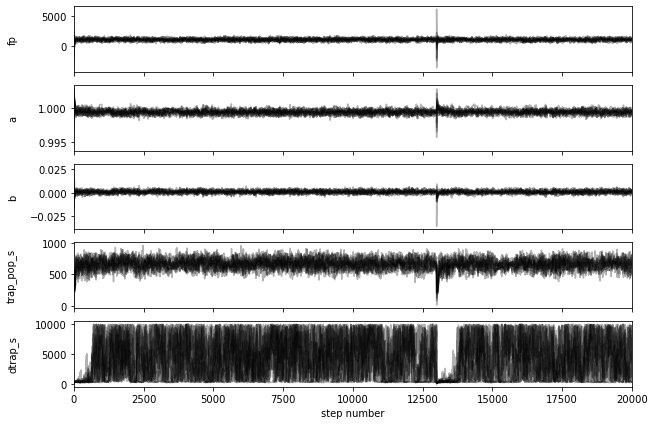

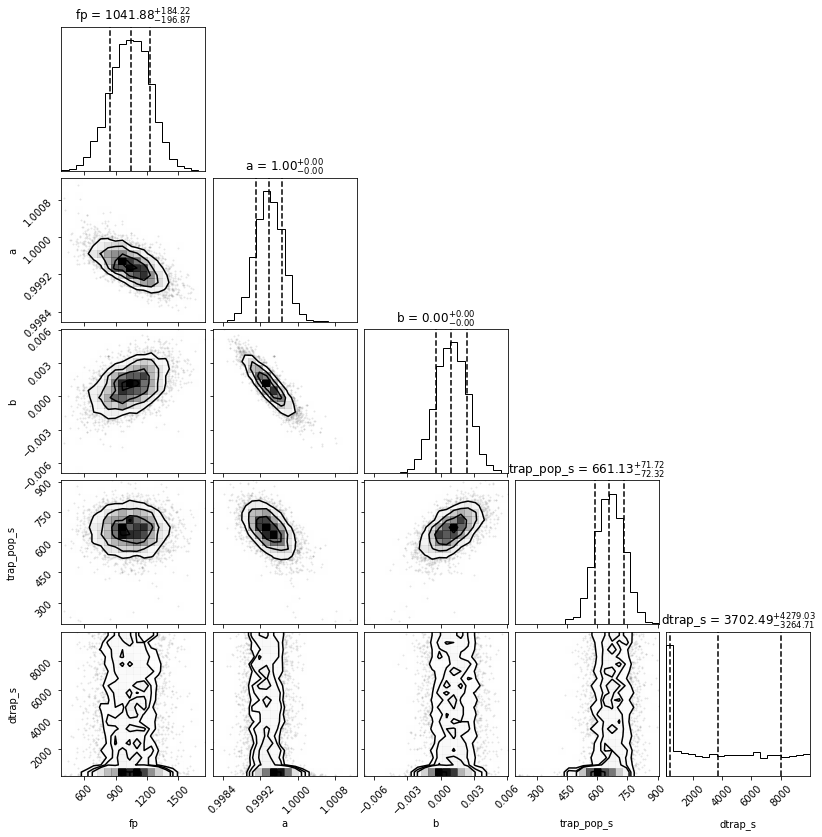

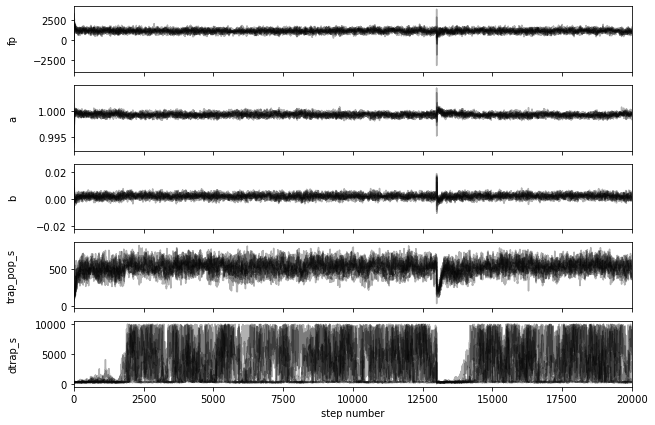

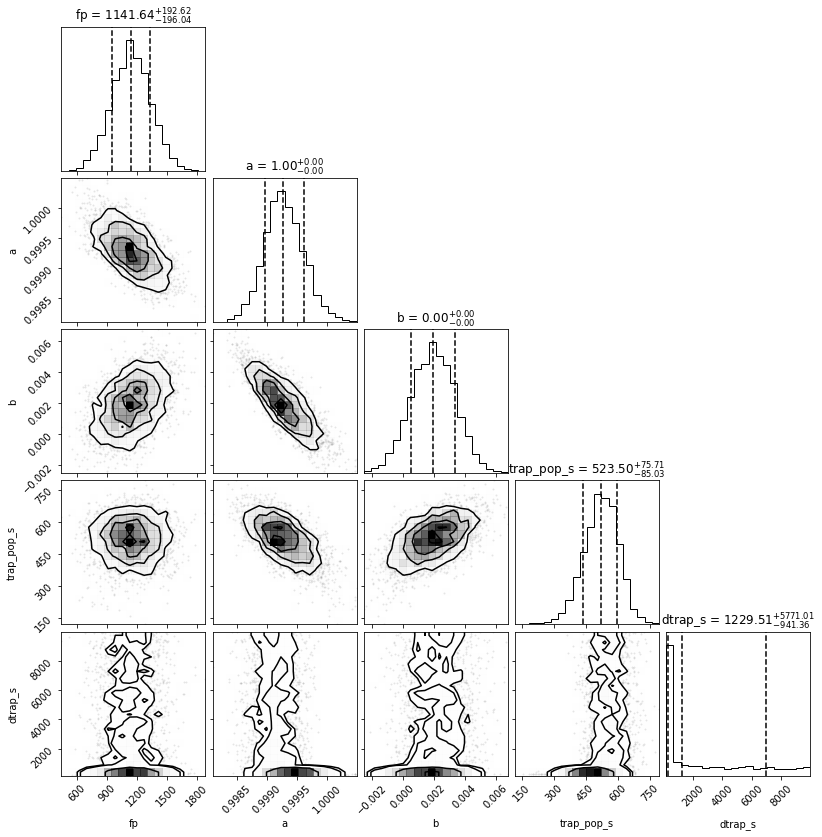

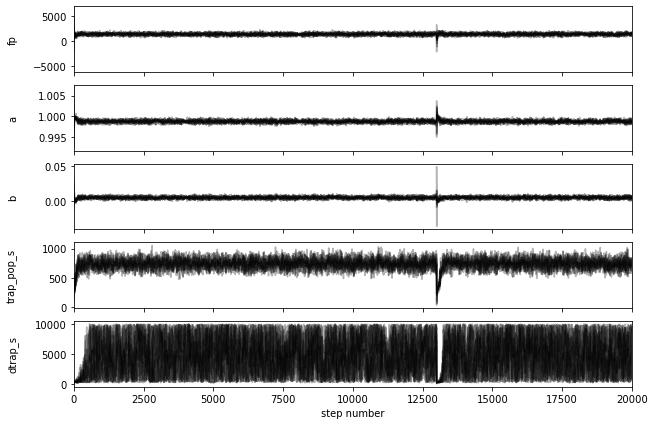

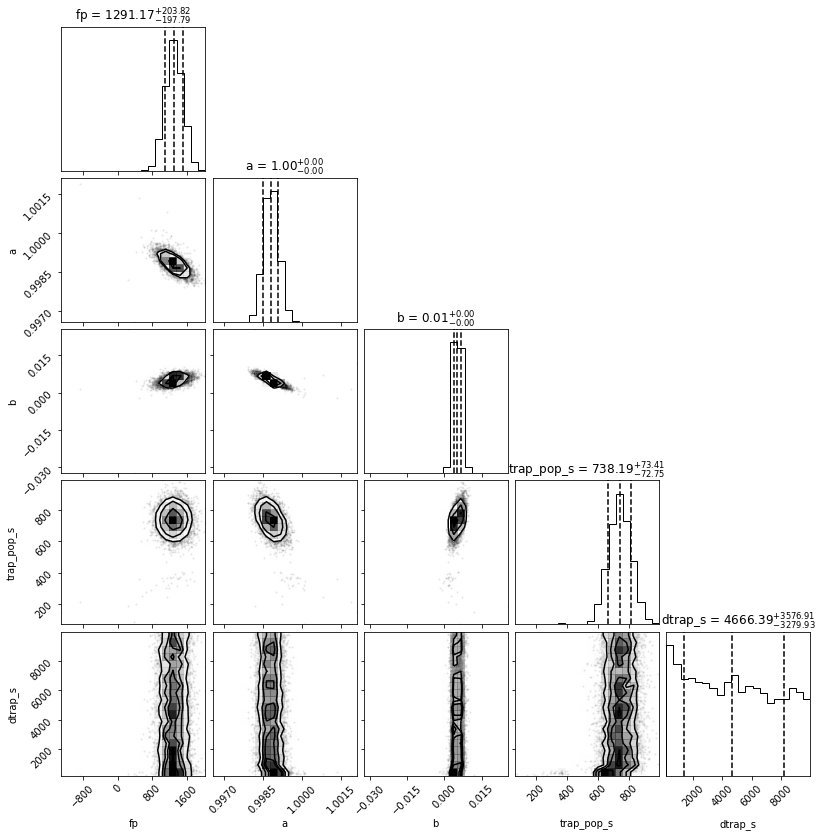

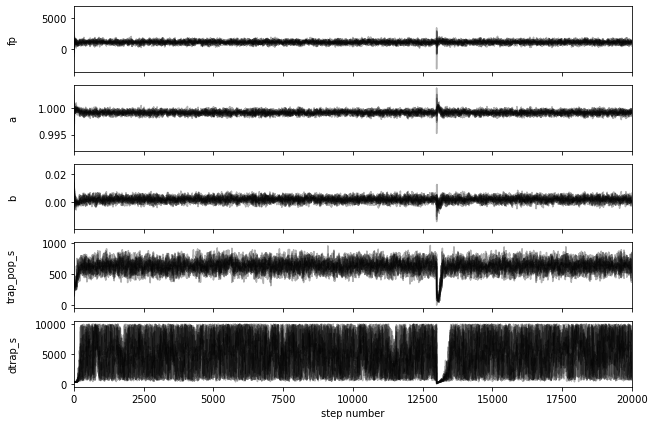

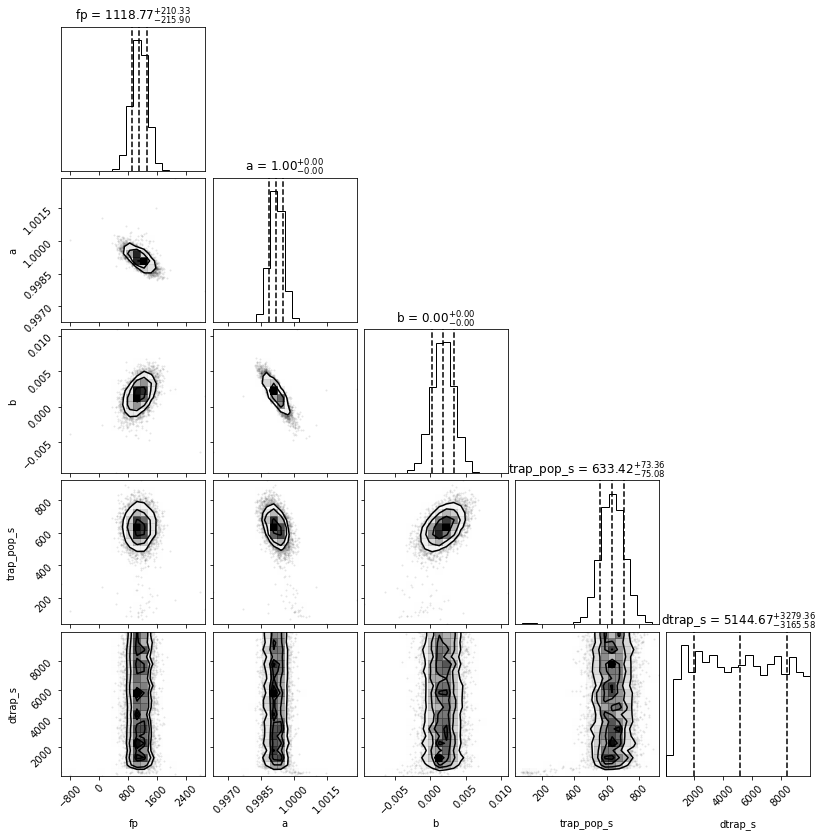

In [549]:
import emcee
start = time.time()
sampler_3 = MCMC(spec_v3,eclipse_model_RECTE,v3_wavebin_channels,20000,nbins=10,recalculate=False,showPlot=True)
end= time.time()
print(f"Runtime of the program is {end - start} seconds")

Text(0, 0.5, 'fp')

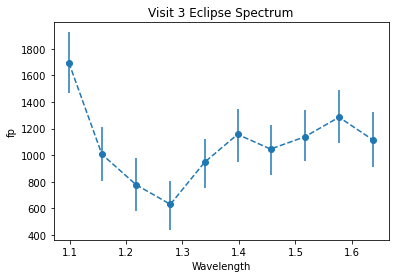

In [515]:
q50_values_3=[item[0] for item in sampler_3[0]]
lower_limit_3=[item[0] for item in sampler_3[1]]
upper_limit_3 = [item[0] for item in sampler_3[2]]

plt.errorbar(wavebins_v3,q50_values_3,yerr=[lower_limit_3, upper_limit_3],fmt='--o')
plt.title("Visit 3 Eclipse Spectrum")
plt.xlabel("Wavelength")
plt.ylabel("fp")

In [518]:
import emcee
start = time.time()
sampler_4 = MCMC(spec_v4,eclipse_model_RECTE,v4_wavebin_channels,13000,nbins=10,recalculate=False,showPlot=False)
end= time.time()
print(f"Runtime of the program is {end - start} seconds")

Solution_x took 0.0 seconds
found
Auto_Correlation Time: [ 78.06731393  95.46880503  79.99946532 100.79631334 144.62357429]
burn-in: 289
thin: 39
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [57.05568145 63.7406143  69.3292595  70.05183665 72.67699219]
burn-in: 145
thin: 28
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [65.64499483 64.98042997 61.8660078  61.35963156 63.46135793]
burn-in: 131
thin: 30
Solution_x took 0.0 seconds
found
Auto_Correlation Time: [61.65602214 70.12703347 71.13157016 72.53537148 76.19308784]
burn-in: 152
thin: 30
Solution_x took 0.0 seconds
found


N/50 = 260;
tau: [ 86.11385249 147.13638611  93.42861506 288.75205364 488.36207147]


Auto_Correlation Time: [ 86.11385249 147.13638611  93.42861506 288.75205364 488.36207147]
burn-in: 976
thin: 43
Solution_x took 0.0 seconds
found


UnboundLocalError: local variable 'samples' referenced before assignment